# Importing Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import re
import nltk
import numpy as np
import pandas as pd
import math
import string
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
nlp = spacy.load('en_core_web_sm')
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# specify GPU
device = torch.device("cuda")

# Data Preprocessing

In [2]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 110.4+ KB


In [7]:
stop_words = set(stopwords.words('english'))
test['selected_text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
test['selected_text'] = test['selected_text'].apply(lambda x: re.sub(r'http\S+', '', x))

def remove_proper_nouns(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    filtered = [word for word, tag in tagged if tag != 'NNP' and word.lower() not in stop_words]
    return ' '.join(filtered)

test['selected_text'] = test['selected_text'].apply(remove_proper_nouns)

In [8]:
test = test[['textID', 'text', 'selected_text', 'sentiment']]

In [9]:
test.head()

,textID,text,selected_text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,Last session day,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,also really exciting ( precisely -- skyscraper...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit , quit company , shame !",negative
3,01082688c6,happy bday!,happy bday !,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,- like ! !,positive


In [10]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [11]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [12]:
#distribution of tweets in dataset
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<AxesSubplot:xlabel='sentiment', ylabel='count'>

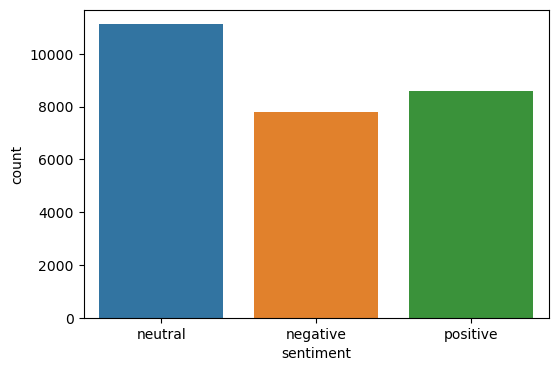

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment',data=train)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

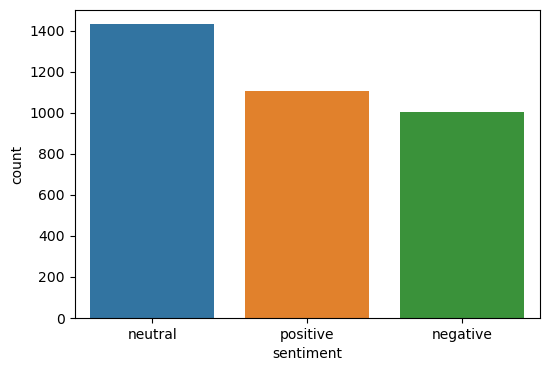

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment',data = test)

In [17]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [18]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [19]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [20]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard, how='outer')

In [21]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [22]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [23]:
test.head()

,textID,text,selected_text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,Last session day,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,also really exciting ( precisely -- skyscraper...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...","Recession hit , quit company , shame !",negative
3,01082688c6,happy bday!,happy bday !,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,- like ! !,positive


In [24]:
#distribution of meta features
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [25]:
k = train[train['Num_word_text']<=2] # checking for similarity between features
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [26]:
k[k['sentiment']=='positive'] # direct corr between text and selected_text

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


In [27]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [28]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [29]:
test['text'] = test['text'].apply(lambda x:clean_text(x))
test['selected_text'] = test['selected_text'].apply(lambda x:clean_text(x))

In [30]:
nlp = spacy.load("en_core_web_sm")

# Define a function to apply lemmatization
def lemmatize(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

# Apply lemmatization to the "selected_text" column
train["selected_text_lemmatized"] = test["selected_text"].apply(lemmatize)
test["selected_text_lemmatized"] = test["selected_text"].apply(lemmatize)


In [31]:
train.head() # cleaned train set

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,selected_text_lemmatized
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,last session day
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8,also really exciting precisely skyscraper ...
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3,recession hit quit company shame
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2,happy bday
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11,like


In [32]:
test.head() # cleaned test set

,textID,text,selected_text,sentiment,selected_text_lemmatized
0,f87dea47db,last session of the day,last session day,neutral,last session day
1,96d74cb729,shanghai is also really exciting precisely s...,also really exciting precisely skyscrapers g...,positive,also really exciting precisely skyscraper ...
2,eee518ae67,recession hit veronique branquinho she has to ...,recession hit quit company shame,negative,recession hit quit company shame
3,01082688c6,happy bday,happy bday,positive,happy bday
4,33987a8ee5,i like it,like,positive,like


# Dataloader, Importing models, Tokenizing

In [33]:
from transformers import ReformerTokenizer, ReformerForSequenceClassification
from torch.utils.data import DataLoader

In [34]:
# loading the pretrained Reformer model
model = ReformerForSequenceClassification.from_pretrained('google/reformer-crime-and-punishment')

You might want to disable causal masking for sequence classification
Some weights of the model checkpoint at google/reformer-crime-and-punishment were not used when initializing ReformerForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing ReformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ReformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ReformerForSequenceClassification were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight',

In [35]:
# customizing the top layer of the model for sentiment analysis
num_labels = 3  # Three-class classification (positive, negative, or neutral)
model.classifier = torch.nn.Linear(model.config.hidden_size, num_labels)

In [36]:
tokenizer = ReformerTokenizer.from_pretrained('google/reformer-crime-and-punishment')
tokenizer.pad_token = tokenizer.eos_token  # Set the padding token to the EOS token

In [37]:
# Encode the training data
train_encodings = tokenizer(train['selected_text'].tolist(), truncation=True, padding=True)
train_labels = torch.tensor(train['sentiment'].astype('category').cat.codes.tolist())

# Encode the testing data
test_encodings = tokenizer(test['selected_text'].tolist(), truncation=True, padding=True)
test_labels = torch.tensor(test['sentiment'].astype('category').cat.codes.tolist())

In [39]:
#converting lists to tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    train_labels
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    test_labels
)

# Training

In [40]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
#train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_dataset)

# dataLoader for train set
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
#val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
#val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
#val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [41]:
# freeze all the parameters
for param in model.parameters():
    param.requires_grad = False

In [43]:
class Reformer_Arch(nn.Module):

    def __init__(self, model):
        super(Reformer_Arch, self).__init__()
        
        self.model = model
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.model(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [46]:
# pass the pre-trained BERT to our define architecture
model_fin = Reformer_Arch(model)

# push the model to GPU
model_fin = model_fin.to(device)

In [47]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

In [48]:
train_labels

tensor([1, 0, 0,  ..., 2, 2, 1])

In [49]:
np.unique(train_labels)

array([0, 1, 2])

In [50]:
# Find all unique labels in train_labels
unique_labels = np.unique(train_labels)

In [51]:
unique_labels

array([0, 1, 2])

In [ ]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes= unique_labels, y= train_labels)
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

print("Class Weights:",class_weights)

In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
    
    model_fin.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model_fin.zero_grad()        

        # get model predictions for the current batch
        preds = model_fin(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model_fin.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
#best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
#valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    #valid_loss, _ = evaluate()
    
    #save the best model
    #if valid_loss < best_valid_loss:
        #best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    #valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    #print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Predictions

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_dataset.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))